#  Image-to-Image Translation with GANs
 

# Outline

This is an excerpt from the Kadenze Training course, Creative Applications of Tensorflow IV - Magenta.

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- [Introduction](#intro)
- [Training Results](#training_results)
    - [Objective](#training_results_obj)
    - [Training Data](#training_results_data)
    - [Training Loss](#training_results_loss)
    
- [Test Data Results](#test_results)
<!-- /MarkdownTOC -->

In [2]:
import sys
# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from music21 import midi
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
    import tensorflow.contrib.layers as tfl
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, datasets, dataset_utils
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

Make sure you have started notebook in the same directory as the provided zip file which includes the 'libs' folder and the file 'utils.py' inside of it.  You will NOT be able to complete this assignment unless you restart jupyter notebook inside the directory created by extracting the zip file or cloning the github repo.


<a name="intro"></a>
## Introduction

### Magenta

Magenta is a research project to advance the state of the art in machine intelligence for music and art generation. Machine learning has already been used extensively to understand content, as in speech recognition or translation. For further details, go to https://magenta.tensorflow.org/welcome-to-magenta

<a name="training_results"></a>
# Training Results

<a name="training_results_obj"></a>
## Objective

The Magenta's Polyphonic RNN API was used for this exercise. This model applies language modeling to polyphonic music generation using an LSTM. Unlike melodies, this model needs to be capable of modeling multiple simultaneous notes.

<a name="training_results_data"></a>
## Training Data
The training data was a set of 15 classical music pieces by Franz Schubert. The files were in a MIDI format.

The collection of MIDI files had to be converted into NoteSequences. NoteSequences are protocol buffers, which is a fast and efficient data format, and easier to work with than MIDI files.

Ensure that magenta is installed.

In [ ]:
!pip install magenta

And run the script to convert the MIDI files into NoteSequences.

In [ ]:
!convert_dir_to_note_sequences --input_dir=music --output_file=/tmp/notesequences_poly.tfrecord

Followed by creating the training dataset

In [ ]:
!polyphony_rnn_create_dataset --input=/tmp/notesequences_poly.tfrecord --output_dir=/tmp/polyphony_rnn/sequence_examples --eval_ratio=0.10

The next command trains a RNN network with 2 layers of 64 weights, with a batch size of 64

In [ ]:
!polyphony_rnn_train \
--run_dir=polyphony_rnn/logdir/run1 \
--sequence_example_file=polyphony_rnn/sequence_examples/training_poly_tracks.tfrecord \
--hparams="batch_size=64,rnn_layer_sizes=[64,64]" \
--num_training_steps=10000

<a name="training_results_loss"></a>
## Training Loss

### Model Convergence

The model's final training results are as follow:
- Iterations: 35347
- Accuracy: 0.857445
- Loss: 0.42489
- Perplexity: 1.52942



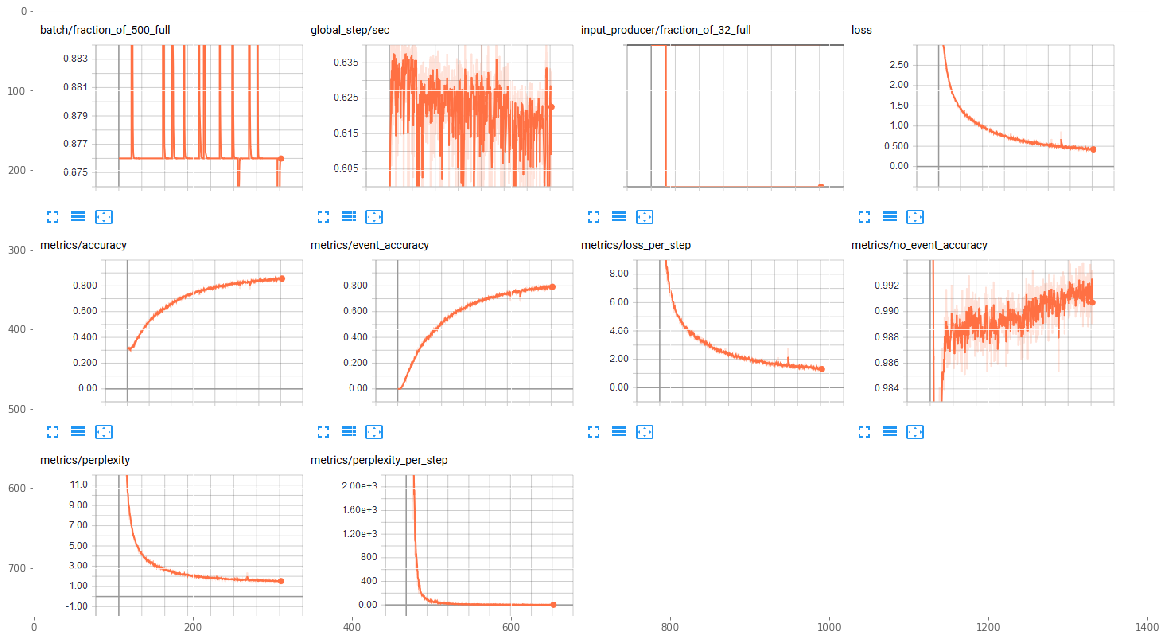

In [3]:
loss_plot = plt.imread('imgs/tensorboard_results.png')
f, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.imshow(loss_plot)

<a name="test_results"></a>
## Test Data Results

So what happens when we present new data to the network?

The API allows the user to present the model with a primer midi. In this instance, I had created music/seed1.mid, which is the first measure of Schubert's Opus 143-3, and music/seed2.mid, which is approximately half of the 1st measure of seed1.mid.

In [7]:
def play_midi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')
play_midi('music/seed1.mid')

In [8]:
play_midi('music/seed2.mid')

Using seed1.mid, the model generated music trained on Schubert, for 128 steps.

In [ ]:
!polyphony_rnn_generate \
--run_dir=polyphony_rnn/logdir/run1 \
--hparams="batch_size=64,rnn_layer_sizes=[64,64]" \
--output_dir=polyphony_rnn/generated \
--num_outputs=1 \
--num_steps=32 \
--primer_midi=polyphony_rnn/sequence_examples/seed.mid \
--condition_on_primer=false \
--inject_primer_during_generation=true



Below is the resulting midi file

In [9]:
play_midi('polyphonic/generated/schubert_2017-12-14_235629_1.mid')

Results were pretty mediocre.

Magenta had also trained a Polyphonic RNN model based on Bach's music. 

Below are the resulting midi files for seed1.mid and seed2.mid. 128 steps were generated for each MIDI. 

In [ ]:
!polyphony_rnn_generate \
--bundle_file=polyphony_rnn.mag \
--output_dir=polyphony_rnn/generated \
--num_outputs=10 \
--num_steps=128 \
--primer_midi=polyphony_rnn/sequence_examples/seed1.mid \
--condition_on_primer=true \
--inject_primer_during_generation=false

In [10]:
play_midi('polyphonic/generated/startSchubert_contBach_2017-12-14_235826_10.mid')

In [ ]:
!polyphony_rnn_generate \
--bundle_file=polyphony_rnn.mag \
--output_dir=polyphony_rnn/generated \
--num_outputs=10 \
--num_steps=128 \
--primer_midi=polyphony_rnn/sequence_examples/seed2.mid \
--condition_on_primer=true \
--inject_primer_during_generation=false

In [11]:
play_midi('polyphonic/generated/startSchubertShort_2017-12-15_000427_08.mid')